# INTRACRANIAL HEMORRHAGE (ICH) DETECTION AND CLASSIFICATION FROMBRAIN COMPUTED TOMOGRAPHY (CT)

DS261 Artificial Intelligence For Medical Image Analysis

Submitted By - Dayita Chaudhuri

SR No. 06-18-01-10-52-24-1-25338

## 1. Imports and Args

In [ ]:
! pip install pydicom

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import torch
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from albumentations import Compose, ShiftScaleRotate, Resize, HorizontalFlip, RandomBrightnessContrast, Normalize
from torchvision.transforms import ToTensor
from albumentations.pytorch import ToTensorV2

import pydicom
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Args:
  def __init__(self) -> None:
      self.saved_model_dir = '/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/models/'
      self.dir_csv = "/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/"
      self.test_images_dir = "/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/stage_2_test/"
      self.train_images_dir = "/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/stage_2_train/"
      self.train_metadata_csv = '/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/metadata/train_metadata_noidx.csv'
      self.COLS = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
      self.metadata_csv = '/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/metadata/'
      self.models_dir = '/content/drive/My Drive/Collab_Datasets/AIMI/Project/RSNA_Dataset/rsna-intracranial-hemorrhage-detection/models/'
      self.n_classes = 6
      self.n_epochs = 3
      self.batch_size = 32

args = Args()

## 2. Dataset Definitions

In [ ]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x >= px_mode] = x[x >= px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000


def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img


def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)

    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380

    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)

    return bsb_img

In [ ]:
class IntracranialDataset(Dataset):

    def __init__(self, csv_file, path, labels, transform=None):
        self.path = path
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            dicom = pydicom.dcmread(self.path + self.data.loc[idx, 'Image'] + '.dcm')
            img = bsb_window(dicom)
        except:
            img = np.zeros((512, 512, 3))

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        image_id = self.data.loc[idx, 'Image']

        if self.labels:

            labels = torch.tensor(
                self.data.loc[
                    idx, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']])
            return {'image': img, 'labels': labels, 'image_id': image_id}

        else:

            return {'image': img, 'image_id': image_id}

In [ ]:
class PredictionsDataset(Dataset):

    def __init__(self, data, col_names, features=120, train=True, series=None):
        self.data = data
        self.train = train
        self.col_names = col_names
        self.embed_cols = [str(i) for i in range(features)]

        if series is None:
            self.series = self.data['SeriesInstanceUID'].unique()
        else:
            self.series = series

    def __len__(self):
        return len(self.series)

    def __getitem__(self, idx):
        series_id = self.series[idx]
        images = self.data[self.data['SeriesInstanceUID'] == series_id].sort_values(by=['ImagePositionSpan', 'ImageId'])

        cols = self.col_names

        image_preds = images[cols].to_numpy().astype(float)

        image_truths = images[self.col_names].to_numpy().astype(float)
        image_embeds = images[self.embed_cols].to_numpy().astype(float)

        return {
            'preds': torch.tensor(image_preds).to(torch.float),
            'labels': torch.tensor(image_truths).to(torch.float),
            'embeds': torch.tensor(image_embeds).to(torch.float)
        }

## 3. Model Definitions

In [ ]:
class ResNeXtModel(torch.nn.Module):
    def __init__(self):
        super(ResNeXtModel, self).__init__()
        resnext = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
        for param in resnext.parameters():
            param.requires_grad = True
        self.base = torch.nn.Sequential(*list(resnext.children())[:-2])
        self.global_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 6)
        )
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, input):
        features = self.base(input)
        features.requires_grad_(True)
        features.register_hook(self.activations_hook)
        pooled_features = self.global_pool(features)
        flattened = pooled_features.reshape(features.size(0), -1)
        out = self.fc(flattened)
        return out, features

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.base(x)


In [ ]:
class EmbeddingSmootherModel(torch.nn.Module):
    def __init__(self, features=120, hidden_size=256):
        super(EmbeddingSmootherModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(features + 6, self.hidden_size, num_layers=3, dropout=0.3, batch_first=True,
                                  bidirectional=True)
        self.scan_rnn = torch.nn.GRU(6, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_size * 2 + 6, 6)
        )
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, seq, preds):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        hidden = (
            torch.zeros(6, 1, self.hidden_size).to(device),
            torch.zeros(6, 1, self.hidden_size).to(device)
        )

        out, hidden = self.lstm(seq, hidden)
        combined_out = torch.cat((out, preds), 2)
        out = self.classifier(self.dropout(combined_out))

        return out

## 4. CNN

#### Train and Test CSV Creation

In [ ]:
train = pd.read_csv(args.dir_csv + 'stage_2_train.csv')
train_metadata_noidx = pd.read_csv(args.train_metadata_csv)

# Prepare train table
train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']

# Remove invalid PNGs
all_files = os.listdir(args.train_images_dir)
dcm_files = [os.path.splitext(file)[0] for file in all_files if file.endswith('.dcm')]
dcm_files = np.array(dcm_files)
train = train[train['Image'].isin(dcm_files)]
merged_train = pd.merge(left=train, right=train_metadata_noidx, how='left', left_on='Image', right_on='ImageId')

In [ ]:
from sklearn.model_selection import train_test_split

grouped_metadata = merged_train.groupby('SeriesInstanceUID')[args.COLS].max().reset_index()
grouped_metadata['class_label'] = np.argmax(grouped_metadata[args.COLS].values, axis=1)

train_series_ids = grouped_metadata['SeriesInstanceUID']
train_labels = grouped_metadata['class_label']
train_series, valid_series = train_test_split(
    train_series_ids,
    test_size=0.20,
    random_state=42,
    stratify=train_labels
)
valid_labels = grouped_metadata[grouped_metadata['SeriesInstanceUID'].isin(valid_series)]['class_label']
valid_series, test_series = train_test_split(
    valid_series,
    test_size=0.50,
    random_state=42,
    stratify=valid_labels
)

train_df = merged_train[merged_train['SeriesInstanceUID'].isin(train_series)]
valid_df = merged_train[merged_train['SeriesInstanceUID'].isin(valid_series)]
test_df = merged_train[merged_train['SeriesInstanceUID'].isin(test_series)]

train_df.to_csv(args.metadata_csv + 'train.csv', index=False)
valid_df.to_csv(args.metadata_csv + 'valid.csv', index=False)
test_df.to_csv(args.metadata_csv + 'test.csv', index=False)

In [ ]:
train_df = pd.read_csv(args.metadata_csv + 'train.csv')
valid_df = pd.read_csv(args.metadata_csv + 'valid.csv')
test_df = pd.read_csv(args.metadata_csv + 'test.csv')

In [ ]:
# Checking label distribution in the training, validation, and test sets
for labels in args.COLS:
    train_label_counts = train_df[labels]
    valid_label_counts = valid_df[labels]
    test_label_counts = test_df[labels]
    print(f"Label: {labels}")
    print("Training set label distribution:")
    threshold = 0.5
    positives = train_label_counts.sum()
    negatives = len(train_label_counts) - positives
    print(f"Positives: {positives}, Negatives: {negatives}")
    print("\nValidation set label distribution:")
    positives = valid_label_counts.sum()
    negatives = len(valid_label_counts) - positives
    print(f"Positives: {positives}, Negatives: {negatives}")
    print("\nTest set label distribution:")
    positives = test_label_counts.sum()
    negatives = len(test_label_counts) - positives
    print(f"Positives: {positives}, Negatives: {negatives}")

    print()


Label: epidural
Training set label distribution:
Positives: 74, Negatives: 18740

Validation set label distribution:
Positives: 19, Negatives: 2354

Test set label distribution:
Positives: 4, Negatives: 2345

Label: intraparenchymal
Training set label distribution:
Positives: 917, Negatives: 17897

Validation set label distribution:
Positives: 117, Negatives: 2256

Test set label distribution:
Positives: 115, Negatives: 2234

Label: intraventricular
Training set label distribution:
Positives: 684, Negatives: 18130

Validation set label distribution:
Positives: 89, Negatives: 2284

Test set label distribution:
Positives: 78, Negatives: 2271

Label: subarachnoid
Training set label distribution:
Positives: 923, Negatives: 17891

Validation set label distribution:
Positives: 112, Negatives: 2261

Test set label distribution:
Positives: 108, Negatives: 2241

Label: subdural
Training set label distribution:
Positives: 1207, Negatives: 17607

Validation set label distribution:
Positives: 183,

#### Dataset Generation

In [ ]:
from albumentations import Compose, Resize, Normalize, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, \
    ElasticTransform, GaussianBlur, RandomCrop, ChannelShuffle, RandomRotate90

# Data Augmentations
transform_1 = Compose([Resize(256, 256)])
transform_2 = Compose([Normalize(mean=[0.1738, 0.1433, 0.1970], std=[0.3161, 0.2850, 0.3111], max_pixel_value=1.)])
transform_3 = Compose([HorizontalFlip()])
transform_4 = Compose([ShiftScaleRotate()])
transform_5 = Compose([RandomBrightnessContrast()])

transform_train = Compose([
    Resize(256, 256),
    Normalize(mean=[0.1738, 0.1433, 0.1970], std=[0.3161, 0.2850, 0.3111], max_pixel_value=1.),
    HorizontalFlip(),
    ShiftScaleRotate(),
    RandomBrightnessContrast(),
    ElasticTransform(alpha=1.0, sigma=50),
    GaussianBlur(blur_limit=3),
    RandomCrop(width=224, height=224),
    ChannelShuffle(),
    ToTensorV2()
])

transform_tta = Compose([
    Resize(256, 256),
    HorizontalFlip(),
    ShiftScaleRotate(),
    RandomRotate90(),
    Normalize(mean=[0.1738, 0.1433, 0.1970], std=[0.3161, 0.2850, 0.3111], max_pixel_value=1.),
    ToTensorV2()
])

transform_test = Compose([
    Resize(256, 256),
    Normalize(mean=[0.1738, 0.1433, 0.1970], std=[0.3161, 0.2850, 0.3111], max_pixel_value=1.),
    ToTensorV2()
])


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


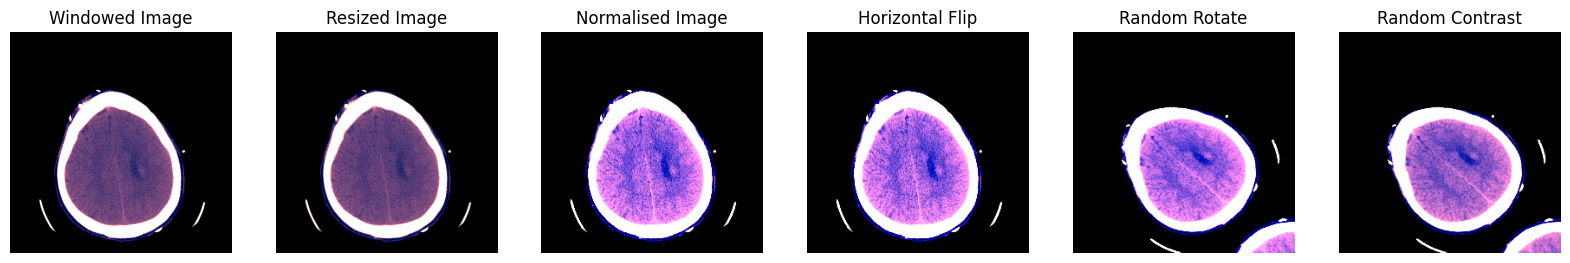

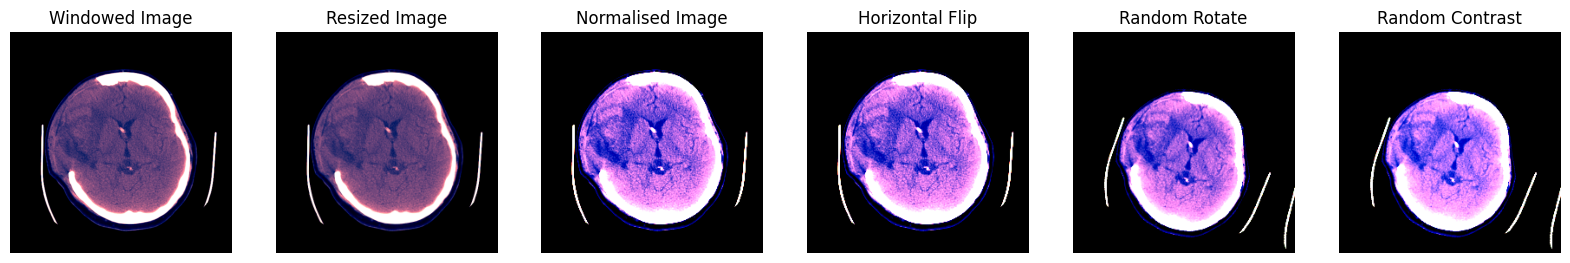

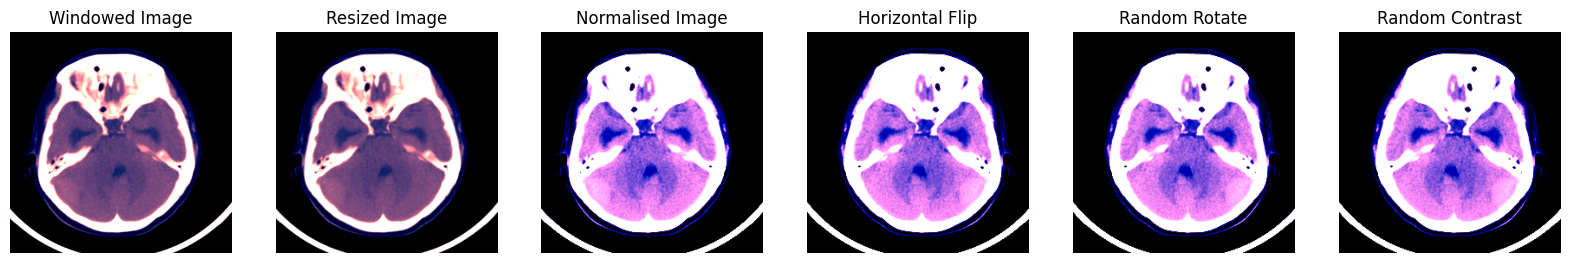

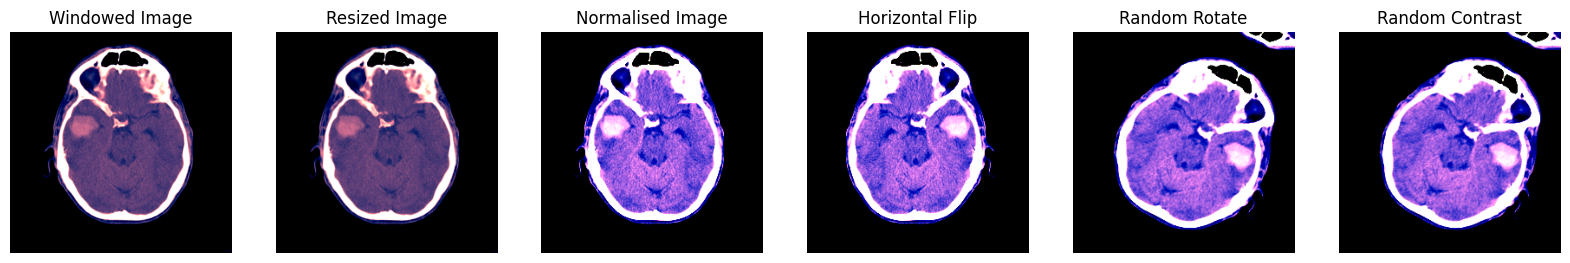

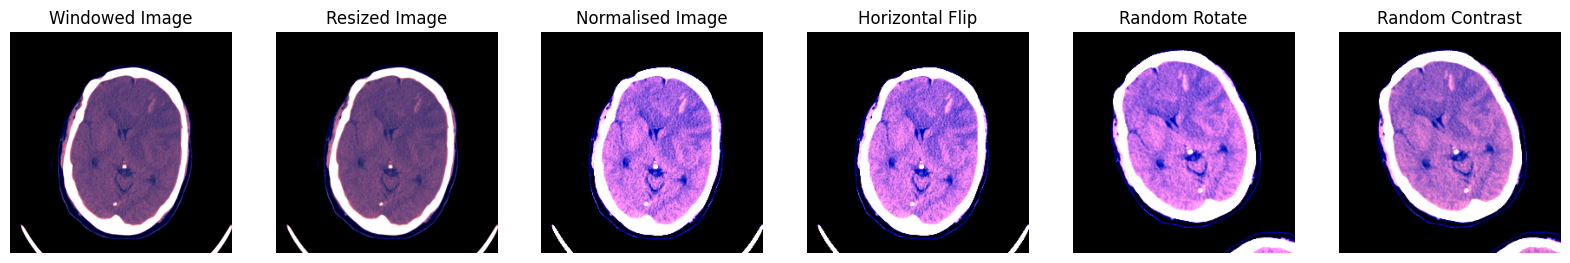

In [ ]:
ID_list = ['ID_00a1d04a4', 'ID_00083d407', 'ID_001212532', 'ID_0002081b6', 'ID_0009e5f5e']
for id in ID_list:
    image = pydicom.dcmread(args.train_images_dir + id + '.dcm')

    brain_windowed = window_image(image, 40, 80)
    brain_windowed = (brain_windowed - 0) / 80

    subdural_windowed = window_image(image, 80, 200)
    subdural_windowed = (subdural_windowed - (-20)) / 200

    soft_windowed = window_image(image, 40, 380)
    soft_windowed = (soft_windowed - (-150)) / 380

    complete_img = np.array([brain_windowed, subdural_windowed, soft_windowed]).transpose(1, 2, 0)

    img_1 = transform_1(image=complete_img)['image']
    img_2 = transform_2(image=img_1)['image']
    img_3 = transform_3(image=img_2)['image']
    img_4 = transform_4(image=img_3)['image']
    img_5 = transform_5(image=img_4)['image']


    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    axes[0].imshow(complete_img, cmap='gray')
    axes[0].set_title('Windowed Image')
    axes[0].axis('off')

    axes[1].imshow(img_1, cmap='gray')
    axes[1].set_title('Resized Image')
    axes[1].axis('off')

    axes[2].imshow(img_2, cmap='gray')
    axes[2].set_title('Normalised Image')
    axes[2].axis('off')

    axes[3].imshow(img_3)
    axes[3].set_title('Horizontal Flip')
    axes[3].axis('off')

    axes[4].imshow(img_4)
    axes[4].set_title('Random Rotate')
    axes[4].axis('off')

    axes[5].imshow(img_5)
    axes[5].set_title('Random Contrast')
    axes[5].axis('off')

    plt.show()

In [ ]:
train_dataset = IntracranialDataset(
    csv_file=args.metadata_csv + 'train.csv', path=args.train_images_dir, transform=transform_train, labels=True)

valid_dataset = IntracranialDataset(
    csv_file=args.metadata_csv + 'valid.csv', path=args.train_images_dir, transform=transform_train, labels=True)

test_dataset = IntracranialDataset(
    csv_file=args.metadata_csv + 'test.csv', path=args.test_images_dir, transform=transform_test, labels=False)

In [ ]:
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
data_loader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

#### Train ResNEXT101 Model

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNeXtModel()
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-5)

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


In [ ]:
min_val_loss = float('inf')
train_loss = []
val_loss = []

for epoch in range(args.n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, args.n_epochs))
    print('-' * 10)

    model.train()
    tr_loss = 0

    for step, batch in enumerate(data_loader_train):
        inputs = batch["image"]
        labels = batch["labels"]

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
          outputs, _ = model(inputs)
          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        tr_loss += loss.item()

        if step % 10 == 0:
            epoch_loss = tr_loss / (step + 1)
            print('Training Loss at {}: {:.4f}'.format(step, epoch_loss))

    epoch_loss = tr_loss / len(data_loader_train)
    print('Training Loss: {:.4f}'.format(epoch_loss))
    print('-----------------------')

    train_loss.append(epoch_loss)

    model.eval()
    vl_loss = 0
    auc_preds = []
    auc_truths = []

    with torch.no_grad():
        for step, batch in enumerate(data_loader_valid):
            inputs = batch["image"]
            labels = batch["labels"]

            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            with autocast(device_type='cuda'):
              outputs, _ = model(inputs)
              loss = criterion(outputs, labels)

            vl_loss += loss.item()
            auc_preds.append(outputs.view(-1, 6).detach().cpu().numpy())
            auc_truths.append(labels.view(-1, 6).detach().cpu().numpy())

    vl_loss = vl_loss / len(data_loader_valid)
    print('Validation Loss: {:.4f}'.format(vl_loss))

    val_loss.append(vl_loss)

    if vl_loss < min_val_loss:
        min_val_loss = vl_loss
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss,
            'train_loss': train_loss
        }
        torch.save(checkpoint, args.models_dir + 'balanced_best_model.pt')

    roc_preds = np.concatenate(auc_preds)
    roc_truths = np.concatenate(auc_truths)

    for tp in range(0, 6):
        print(args.COLS[tp], roc_auc_score(roc_truths[:, tp], roc_preds[:, tp]), )
    print('-----------------------')

In [ ]:
checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss,
            'train_loss': train_loss
        }
torch.save(checkpoint, args.models_dir + 'new_best_model.pt')


#### Load Model from Last saved state

In [ ]:
checkpoint = torch.load(args.models_dir + 'new_best_model.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

model = ResNeXtModel().to(device)
model.load_state_dict(checkpoint['model'])

optimizer_loaded = torch.optim.Adam(model.parameters())
optimizer_loaded.load_state_dict(checkpoint['optimizer'])

prev_epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
min_val_loss = float('inf')

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


## 5. LSTM

#### Feature Selection Using PCA

In [ ]:
PCA_BATCHES = 1000
model = model.to(device)
model.eval()

train_embed_dict = {}

for i, x_batch in enumerate(tqdm(data_loader_train)):
    x_images = x_batch['image_id']
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)

    if i > PCA_BATCHES:
        break

    with torch.no_grad():
        _, embed = model(x_batch)

        for x, y in zip(x_images, embed):
            e = y.squeeze().detach().cpu().numpy()
            if e.ndim > 1:
                e = e.flatten()
            train_embed_dict[x] = e

emb_stat = np.array(list(train_embed_dict.values()))
print(np.mean(emb_stat), np.std(emb_stat))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=126)

pca.fit(emb_stat)

model.eval()

#### Create Embedding for Training Dataset



In [ ]:
train_pred_dict = {}
train_embed_dict = {}

for i, x_batch in enumerate(tqdm(data_loader_train)):
    x_images = x_batch['image_id']
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)

    with torch.no_grad():

        pred, embed = model(x_batch)
        pred = torch.sigmoid(pred)

        for x, y in zip(x_images, pred):
            y = y.detach().cpu().numpy()
            train_pred_dict[x] = dict(zip(args.COLS, y))
        for x, y in zip(x_images, embed):
            e = y.squeeze().detach().cpu().numpy()
            e = np.expand_dims(e, axis=0)
            train_embed_dict[x] = pca.transform(e)[0]

In [ ]:
train_embed_df = pd.DataFrame.from_dict(train_embed_dict, orient='index')
train_embed_df.to_csv(args.metadata_csv + 'new_train_embeds.csv')

train_pred_df = pd.DataFrame.from_dict(train_pred_dict, orient='index')
train_pred_df.to_csv(args.metadata_csv + 'new_train_preds.csv')

In [ ]:
train_pred_df

#### Create Embedding for Validation Dataset

In [ ]:
valid_pred_dict = {}
valid_embed_dict = {}

for i, x_batch in enumerate(tqdm(data_loader_valid)):
    x_images = x_batch['image_id']
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)

    with torch.no_grad():

        pred, embed = model(x_batch)
        pred = torch.sigmoid(pred)

        for x, y in zip(x_images, pred):
            y = y.detach().cpu().numpy()
            valid_pred_dict[x] = dict(zip(args.COLS, y))
        for x, y in zip(x_images, embed):
            e = y.squeeze().detach().cpu().numpy()
            e = np.expand_dims(e, axis=0)
            valid_embed_dict[x] = pca.transform(e)[0]

In [ ]:
valid_embed_df = pd.DataFrame.from_dict(valid_embed_dict, orient='index')
valid_embed_df.to_csv(args.metadata_csv + 'new_valid_embeds.csv')

valid_pred_df = pd.DataFrame.from_dict(valid_pred_dict, orient='index')
valid_pred_df.to_csv(args.metadata_csv + 'new_valid_preds.csv')

In [ ]:
valid_pred_df

#### Create Embedding for Testing Dataset

In [ ]:
test_pred_dict = {}
test_embed_dict = {}

for i, x_batch in enumerate(tqdm(data_loader_test)):
    x_images = x_batch['image_id']
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)

    with torch.no_grad():

        pred, embed = model(x_batch)
        pred = torch.sigmoid(pred)

        for x, y in zip(x_images, pred):
            y = y.detach().cpu().numpy()
            test_pred_dict[x] = dict(zip(args.COLS, y))
        for x, y in zip(x_images, embed):
            e = y.squeeze().detach().cpu().numpy()
            e = np.expand_dims(e, axis=0)
            test_embed_dict[x] = pca.transform(e)[0]

In [ ]:
test_embed_df = pd.DataFrame.from_dict(test_embed_dict, orient='index')
test_embed_df.to_csv(args.metadata_csv + 'new_test_embeds.csv')

test_pred_df = pd.DataFrame.from_dict(test_pred_dict, orient='index')
test_pred_df.to_csv(args.metadata_csv + 'new_test_preds.csv')

In [ ]:
test_pred_df

#### Read the saved CNN embedding and use ut to Generate embedding data for LSTM training

In [ ]:
train_metadata = pd.read_csv(args.train_metadata_csv)

test_preds = pd.read_csv(f'{args.metadata_csv}new_test_preds.csv', index_col=False)
valid_preds = pd.read_csv(f'{args.metadata_csv}new_valid_preds.csv', index_col=False)
train_preds = pd.read_csv(f'{args.metadata_csv}new_train_preds.csv', index_col=False)

test_preds.rename(columns={'Unnamed: 0': 'Image'}, inplace=True)
valid_preds.rename(columns={'Unnamed: 0': 'Image'}, inplace=True)
train_preds.rename(columns={'Unnamed: 0': 'Image'}, inplace=True)

valid_embeds = pd.read_csv(f'{args.metadata_csv}new_valid_embeds.csv', index_col=False)
train_embeds = pd.read_csv(f'{args.metadata_csv}new_train_embeds.csv', index_col=False)
test_embeds = pd.read_csv(f'{args.metadata_csv}new_test_embeds.csv', index_col=False)

valid_embeds.rename(columns={'Unnamed: 0': 'Image'}, inplace=True)
train_embeds.rename(columns={'Unnamed: 0': 'Image'}, inplace=True)
test_embeds.rename(columns={'Unnamed: 0': 'Image'}, inplace=True)

FEATURES = train_embeds.columns.size - 1

In [ ]:
merged_train = pd.merge(left=train_preds, right=train_metadata, how='left', left_on='Image', right_on='ImageId')
merged_valid = pd.merge(left=valid_preds, right=train_metadata, how='left', left_on='Image', right_on='ImageId')
merged_test = pd.merge(left=test_preds, right=train_metadata, how='left', left_on='Image', right_on='ImageId')

merged_train = pd.merge(left=merged_train, right=train_embeds, how='left', left_on='Image', right_on='Image')
merged_valid = pd.merge(left=merged_valid, right=valid_embeds, how='left', left_on='Image', right_on='Image')
merged_test = pd.merge(left=merged_test, right=test_embeds, how='left', left_on='Image', right_on='Image')

In [ ]:
train_dataset_lstm = PredictionsDataset(merged_train, args.COLS, 126, True, None)
valid_dataset_lstm  = PredictionsDataset(merged_valid, args.COLS, 126, True, None)
test_dataset_lstm  = PredictionsDataset(merged_test, args.COLS, 126, False, None)

data_loader_train_lstm  = torch.utils.data.DataLoader(train_dataset_lstm, batch_size=1, shuffle=True, num_workers=4)
data_loader_valid_lstm  = torch.utils.data.DataLoader(valid_dataset_lstm, batch_size=1, shuffle=False, num_workers=4)
data_loader_test_lstm  = torch.utils.data.DataLoader(test_dataset_lstm, batch_size=1, shuffle=False, num_workers=4)

#### Train the LSTM Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_model = EmbeddingSmootherModel(120, 256)

embedding_model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
plist = [
    {'params': embedding_model.parameters(), 'lr': 3e-5},
]
optimizer = Adam(plist, lr=3e-5)

In [ ]:
n_epochs = 5
min_val_loss_lstm = float('inf')

train_loss = []
val_loss = []

for epoch in range(n_epochs):

    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    print('-' * 10)

    embedding_model.train()
    tr_loss = 0.
    st_loss = 0.

    auc_preds = []
    auc_truths = []

    for step, batch in enumerate(data_loader_train_lstm):
        inputs = batch["preds"]
        labels = batch["labels"]
        embeds = batch["embeds"]
        if step == 0:
            print(embeds.shape)

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        embeds = embeds.to(device, dtype=torch.float)

        outputs = embedding_model(embeds, inputs)
        loss = criterion(outputs.view(-1, 6), labels.view(-1, 6))

        tr_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if step % 500 == 0:
            epoch_loss = tr_loss / (step + 1)
            print('Training Loss at {}: {:.4f}'.format(step, epoch_loss))

    epoch_loss = tr_loss / len(data_loader_train)
    print('Training Loss: {:.4f}'.format(epoch_loss))
    train_loss.append(epoch_loss)

    embedding_model.eval()
    vl_loss = 0.
    st_loss = 0.

    auc_preds = []
    auc_truths = []
    auc_preds_individual = []
    auc_truths_individual = []

    for step, batch in enumerate(data_loader_valid_lstm):
        inputs = batch["preds"]
        labels = batch["labels"]
        embeds = batch["embeds"]

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        embeds = embeds.to(device, dtype=torch.float)

        outputs = embedding_model(embeds, inputs)

        vl_loss += criterion(outputs.view(-1, 6), labels.view(-1, 6)).item()

        outputs = torch.sigmoid(outputs)

        detached_outputs = outputs.view(-1, 6).detach().cpu().numpy()
        detached_labels = labels.view(-1, 6).detach().cpu().numpy()

        auc_preds.append(np.max(detached_outputs, axis=0))
        auc_truths.append(np.max(detached_labels, axis=0))

        for o, l in zip(detached_outputs, detached_labels):
            auc_preds_individual.append(o)
            auc_truths_individual.append(l)

    epoch_loss = vl_loss / len(data_loader_valid)
    val_loss.append(epoch_loss)

    if epoch_loss < min_val_loss_lstm:
        min_val_loss_lstm = epoch_loss
        checkpoint = {
            'model': embedding_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': epoch_loss,
            'train_loss': epoch_loss
        }
        torch.save(checkpoint, args.models_dir + 'new_best_lstm_model.pt')

    roc_preds = np.array(auc_preds)
    roc_truths = np.array(auc_truths)

    roc_preds_individual = np.array(auc_preds_individual)
    roc_truths_individual = np.array(auc_truths_individual)

    print('Validation Loss: {:.4f}'.format(epoch_loss))

    threshold = 0.5
    binary_preds = (roc_preds >= threshold).astype(int)
    binary_preds_individual = (roc_preds_individual >= threshold).astype(int)
    binary_truths = (roc_truths >= threshold).astype(int)
    binary_truths_individual = (roc_truths_individual >= threshold).astype(int)

    print('-----------F1/Sens/Spec-----------')
    for tp in range(0, 6):
        print(args.COLS[tp])
        print(classification_report(binary_truths[:, tp], np.round(binary_preds[:, tp]), digits=4))
    print('---------------------------------')
    print('-----------F1/Sens/Spec-----------')
    for tp in range(0, 6):
        print(args.COLS[tp])
        print(classification_report(binary_truths_individual[:, tp], np.round(binary_preds_individual[:, tp]), digits=4))
    print('---------------------------------')

In [ ]:
checkpoint = torch.load(args.models_dir + 'new_best_lstm_model.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

embedding_model = EmbeddingSmootherModel(120, 256)
embedding_model.load_state_dict(checkpoint['model'])

optimizer_loaded = torch.optim.Adam(embedding_model.parameters())
optimizer_loaded.load_state_dict(checkpoint['optimizer'])

#### Test on inputs and find metrics

In [ ]:
embedding_model.to(device)
cols = args.COLS
results = []

embedding_model.eval()
for step, batch in enumerate(tqdm(data_loader_valid_lstm)):
    seriesId = valid_dataset_lstm.series[step]
    images = valid_dataset_lstm.data[valid_dataset_lstm.data['SeriesInstanceUID'] == seriesId].sort_values(
        by=['ImagePositionSpan', 'ImageId']).ImageId.to_numpy()
    x_batch = batch["embeds"]
    x_batch_x = batch["preds"]
    with torch.no_grad():
        preds = embedding_model(x_batch.to(device, dtype=torch.float), x_batch_x.to(device, dtype=torch.float))
        preds = torch.sigmoid(preds)

        preds = preds.detach().cpu().numpy()[0]
        for img, pred in zip(images, preds):
            res = {
                'Image': img
            }
            for x, y in zip(cols, pred):
                res[x] = y
            results.append(res)

  0%|          | 0/1442 [00:00<?, ?it/s]

In [ ]:
sub_df = pd.DataFrame(results)
sub_df.to_csv(args.dir_csv + 'embedding_sub.csv', index=False)

In [ ]:
def convert_to_binary(data):
  for entry in data:
    for key, value in entry.items():
        if key != 'Image':
            entry[key] = 1 if value >= 0.5 else 0
  return data

binary_results = convert_to_binary(results)

In [ ]:
bin_df = pd.DataFrame(binary_results)
bin_df.to_csv(args.dir_csv + 'binary_sub.csv', index=False)

In [ ]:
columns_to_transform = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
valid_preds[columns_to_transform] = valid_preds[columns_to_transform].applymap(lambda x: 1 if x >= 0.5 else 0)


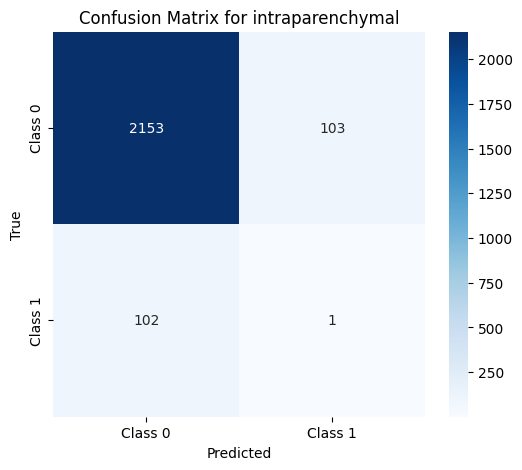

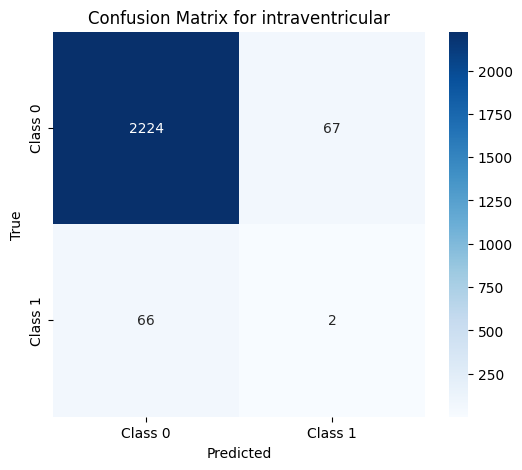

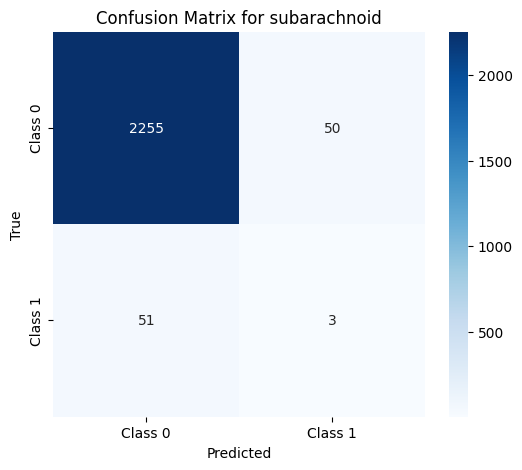

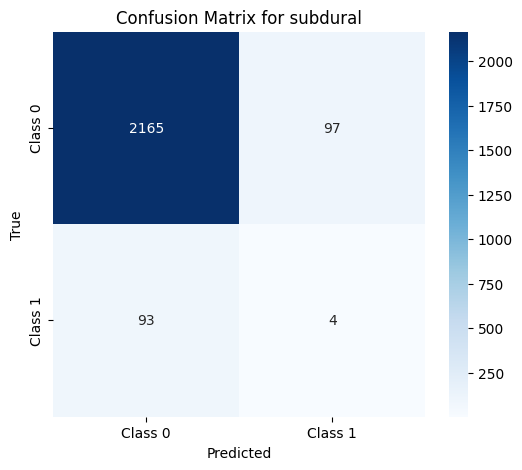

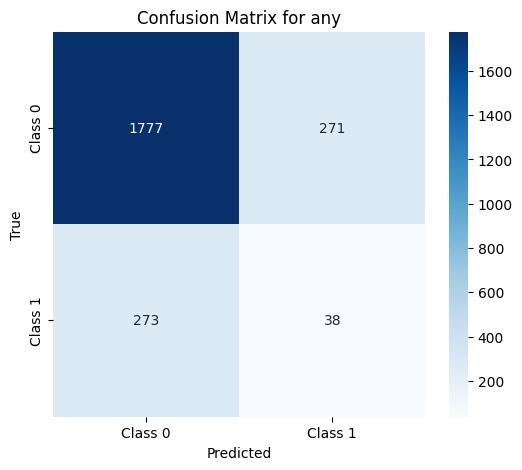


Accuracy per class:
intraparenchymal: 0.9130987706655362
intraventricular: 0.9436201780415431
subarachnoid: 0.9571852479864349
subdural: 0.9194573972022043
any: 0.7693938109368377

Sensitivity per class:
intraparenchymal: 0.009708737864077669
intraventricular: 0.029411764705882353
subarachnoid: 0.05555555555555555
subdural: 0.041237113402061855
any: 0.12218649517684887

Specificity per class:
intraparenchymal: [array([0.95434397, 0.5       , 0.49756098, 0.00961538]), array([0.95476718, 0.50243902, 0.5       , 0.00970874])]
intraventricular: [array([0.97075513, 0.5       , 0.4962406 , 0.02898551]), array([0.97117904, 0.5037594 , 0.5       , 0.02941176])]
subarachnoid: [array([0.97830803, 0.5       , 0.5049505 , 0.05660377]), array([0.97788378, 0.4950495 , 0.5       , 0.05555556])]
subdural: [array([0.9571176 , 0.5       , 0.48947368, 0.03960396]), array([0.95881311, 0.51052632, 0.5       , 0.04123711])]
any: [array([0.86767578, 0.5       , 0.50183824, 0.12297735]), array([0.86682927, 0

In [ ]:
columns = ['intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

metrics = {
    'accuracy': {},
    'sensitivity': {},
    'specificity': {},
    'roc_auc': {},
    'confusion_matrix': {}
}

def plot_confusion_matrix(cm, class_name, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(cm.shape[1])], yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

for col in columns:
    y_true = valid_preds[col].values
    y_pred = bin_df[col].values

    accuracy = accuracy_score(y_true, y_pred)
    metrics['accuracy'][col] = accuracy

    sensitivity = recall_score(y_true, y_pred, average='binary')
    metrics['sensitivity'][col] = sensitivity

    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'][col] = cm

    plot_confusion_matrix(cm, col)

    specificity_per_class = []
    for i in range(len(cm)):
        tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else cm[i, i], cm[i, :].sum() - cm[i, i], cm[:, i].sum() - cm[i, i], cm.sum() - cm[:, i].sum() - cm[i, :].sum() + cm[i, i]
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

    metrics['specificity'][col] = specificity_per_class

    if len(np.unique(y_true)) > 1 and len(np.unique(y_pred)) > 1:
        roc_auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    else:
        roc_auc = None
    metrics['roc_auc'][col] = roc_auc

for metric in metrics:
    print(f"\n{metric.capitalize()} per class:")
    for class_name, value in metrics[metric].items():
        print(f"{class_name}: {value}")


## 6. Grad CAM Visualisation


In [ ]:
import cv2
import torch.nn.functional as F


def grad_cam(model, image, class_idx=None):
    model.eval()
    output, features = model(image)

    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    model.zero_grad()

    target = output[0][class_idx]
    target.backward()

    gradients = model.get_activations_gradient()
    activations = model.get_activations(image)

    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    weighted_activations = weights * activations
    weighted_activations = torch.sum(weighted_activations, dim=1, keepdim=True)
    weighted_activations = F.relu(weighted_activations)
    weighted_activations = weighted_activations.squeeze().cpu().detach().numpy()
    weighted_activations -= np.min(weighted_activations)
    weighted_activations /= np.max(weighted_activations)

    return weighted_activations


def visualize_gradcam(activation_map, image):
    activation_map = cv2.resize(activation_map, (image.shape[1], image.shape[0]))
    image = np.uint8(image * 255)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    activation_map = cv2.applyColorMap(np.uint8(activation_map * 255), cv2.COLORMAP_JET)

    blended = cv2.addWeighted(image, 0.6, activation_map, 0.4, 0)

    return blended

In [ ]:
def load_dicom_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    image_data = dicom_data.pixel_array
    image_data = np.uint8(image_data)
    return image_data

def convert_to_tensor(image_data):
    tensor_data = torch.from_numpy(image_data).float()
    return tensor_data

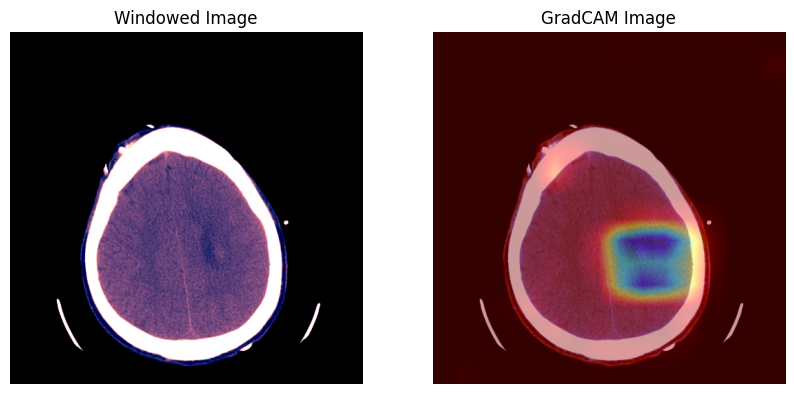

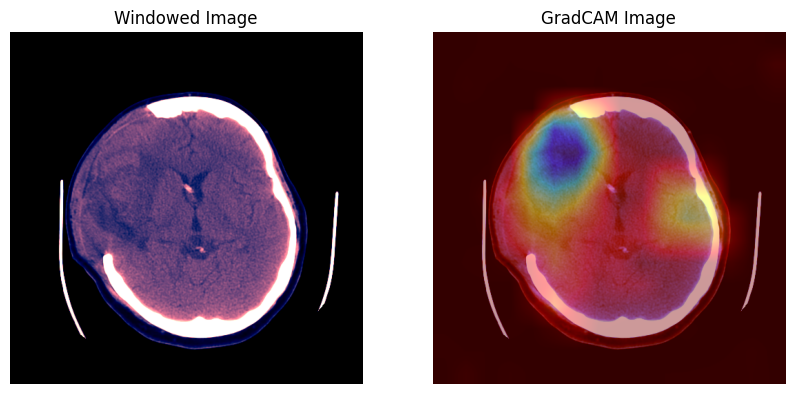

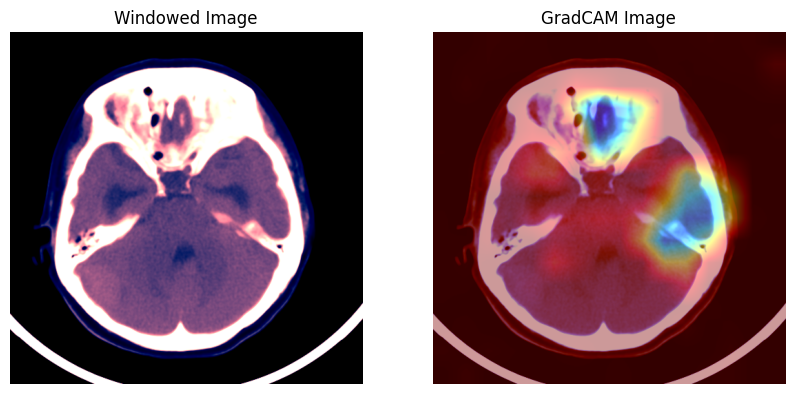

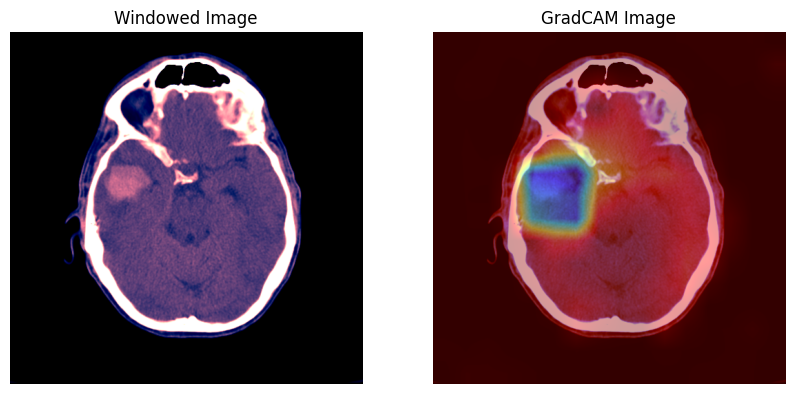

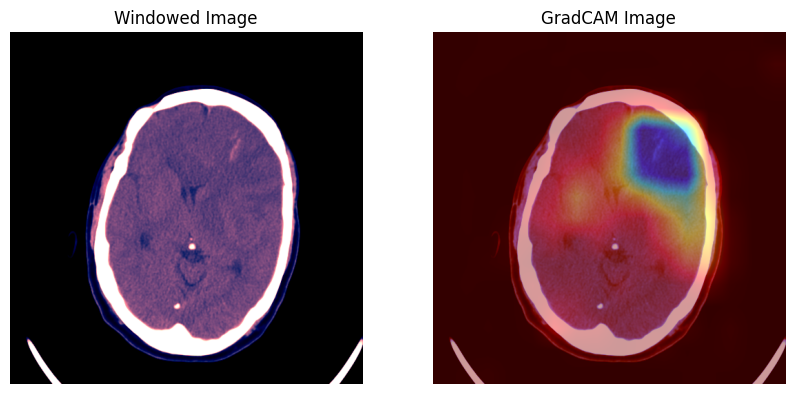

In [ ]:
ID_list = ['ID_00a1d04a4', 'ID_00083d407', 'ID_001212532', 'ID_0002081b6', 'ID_0009e5f5e']
model = model.to(device)
for id in ID_list:
    image = pydicom.dcmread(args.train_images_dir + id + '.dcm')
    image = bsb_window(image)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Windowed Image')
    axes[0].axis('off')

    input_tensor = convert_to_tensor(image)
    input_tensor = input_tensor.permute(2, 0, 1)
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device, dtype=torch.float)
    activation_map = grad_cam(model, input_tensor)
    blended_map = visualize_gradcam(activation_map, image)

    axes[1].imshow(blended_map)
    axes[1].set_title('GradCAM Image')
    axes[1].axis('off')

    plt.show()